In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

We begin by generating some data. We use only 3 data points. 

Data is generated using a linear model
$$
y = \textbf{w}^T x + \epsilon
$$
where $\epsilon \sim N(0, \sigma_n)$. We augment each data point by appending a 1 and let w_2 represent the offset. 

In [14]:
# Data parameters
sigma_n = 1
p = 5  # degree of polynomial
x = np.linspace(-2, 2, 10) #np.array([-5, 1.5, 5, 1, 4.5, 4.6, 4.7, 4.8, 4.9, 4.95])  # hand pick some points, because we're only using 32
n = len(x)  # num data points
D = p + 1  # dimension (including offset)
w = np.zeros(D)
w[1] = 1.5  # parameter we're trying to estimate

# compute y
X = np.vstack([x**i for i in range(p+1)])
w = np.array(w).reshape(D, 1)
y = w.T @ X + np.random.normal(size=(n,))*sigma_n
y = y.T
X.shape

(6, 10)

We choose a prior and plot it below. 

In [3]:
# prior parameters 
mu_p = np.zeros(D)
Sigma_p = np.eye(D)
prior = multivariate_normal(mu_p, Sigma_p).pdf

# # Generate contour plot
if D==2:
    xv = np.linspace(-2, 2, 50)
    yv = np.linspace(-2, 2, 50)

    Xv, Yv = np.meshgrid(xv, yv)
    W = torch.tensor([Xv.tolist(), Yv.tolist()]).reshape(2, -1).T.tolist()
    Z = []

    for w in W:
        Z.append(prior(w))

    Z = np.array(Z).reshape(50, 50)

    plt.contour(Xv, Yv, Z, colors='black');

Now, we construct the likelihood.

In [4]:
def likelihood(W): 
    out = []
    for w in W.T:
        w.tolist()
        res = (2*np.pi*sigma_n**2)**(D/2)*np.exp(-1/(2*sigma_n**2)*np.linalg.norm(y - X.T @ np.array(w).reshape(D,1)))
        out.append(res.tolist())
    return np.array(out).reshape(50, 50)

# Generate contour plot
if D == 2:
    W = torch.tensor([Xv.tolist(), Yv.tolist()])
    Z = likelihood(W.view(D,-1).numpy())

    plt.contour(Xv, Yv, Z.T, colors='black');

In [5]:
# compute mean and covariance for posterior 
A = sigma_n**-2 * X@X.T + np.linalg.inv(Sigma_p)
A_inv = np.linalg.inv(A)
mu = sigma_n**-2 * A_inv @ X @ y
cov = A_inv

# define posterior
posterior = multivariate_normal(mu.squeeze(), cov).pdf

# plot contours
if D == 2:
    Z = []
    W = torch.tensor([Xv.tolist(), Yv.tolist()]).view(2,-1)
    # print(W.T.tolist())
    # posterior([-5.0, 5.0])
    for w in W.T.tolist():
        Z.append(posterior(w))
    Z = np.array(Z).reshape(50,50)
    plt.contour(Xv, Yv, Z.T, colors='black');

Plot posterior predictive distribution. The mean is plotted along with one standard deviation from the mean. 

Something interesting to note in this plot is that a "standard deviation" in the posterior predictive distribution isn't meant to approximate one standard deviation of the slice of data at x. So what exactly is the standard deviation and the posterior predictive distribution measuring? 

All we've tried to do here is estimate the true w. Nowhere in this framework did we try to estimate the noise variance. As we collect more data, the posterior concentrates on a single point. The posterior predictive distribution is just showing a region where the "true" mean line should be running. 

Note that this is also seen in GPs. TODO: How does one compensate for this in GPs? And how is that reflected here?

(50, 1)

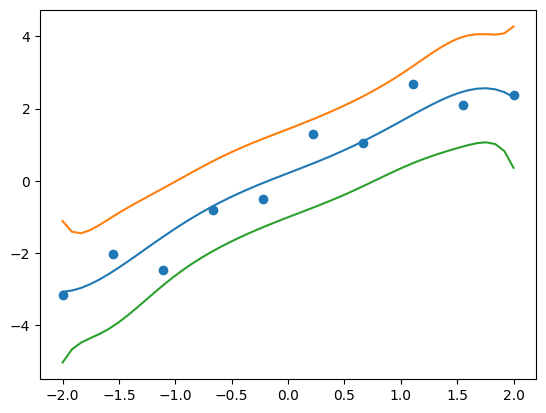

In [18]:
xv = np.linspace(-2, 2, 50)
x_aug = np.array([xv**i for i in range(p+1)])
y_mean = 1/sigma_n**2 * x_aug.T @ A_inv @ X @ y
sigma_pred = np.diag(x_aug.T @ A_inv @ x_aug).reshape(-1,1)  + sigma_n
plt.plot(xv, y_mean, xv, y_mean + sigma_pred, xv, y_mean - sigma_pred)
plt.scatter(x, y)
sigma_pred.shape